# Long Short-Term Memory (LSTM)

Las redes LSTM son muy eficientes para datos secuenciales, donde el orden importa. Piensa en texto (una secuencia de palabras), series temporales (precios de acciones a lo largo del tiempo o temperatura) o audio.

Tienen un "estado interno" o "memoria" que se actualiza en cada paso de la secuencia. Esto les permite recordar información de pasos anteriores para tomar decisiones en el presente. 

Ejemplos: Predecir la siguiente palabra en una oración, clasificar el sentimiento de una reseña de película, o predecir el clima de mañana basándose en los datos de la última semana.

### Dataset
Crearemos uno: una simple onda senoidal. Esto es ideal porque es un patrón periódico y predecible, lo que nos permite verificar visualmente si nuestro modelo está aprendiendo correctamente.

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import LeaveOneGroupOut
from tensorflow.keras import Input
import pandas as pd
import numpy as np
import tensorflow as tf

In [2]:
def create_subject_sequences(X, y, subjects, window_size=10, stride=1):
    """
    Genera secuencias tipo sliding window de largo window_size
    para cada sujeto por separado.

    Parámetros:
        X: np.ndarray de forma (N, F) con todas las muestras
        y: np.ndarray de forma (N,) con etiquetas bin. por muestra
        subjects: np.ndarray de forma (N,) con id de sujeto por muestra
        window_size: int, número de filas por secuencia
        stride: int, paso entre ventanas deslizantes

    Devuelve:
        X_seq: np.ndarray (M, window_size, F)
        y_seq: np.ndarray (M,)          -- etiqueta de la última muestra de cada ventana
        subj_seq: np.ndarray (M,)       -- id de sujeto de cada secuencia
    """
    X_seqs, y_seqs, subj_seqs = [], [], []
    for subj in np.unique(subjects):
        mask = (subjects == subj)
        X_subj = X[mask]
        y_subj = y[mask]

        # ⚠️ Normalización z-score por sujeto
        mean = np.mean(X_subj, axis=0)
        std = np.std(X_subj, axis=0)
        std[std == 0] = 1  # Evitar división por cero
        X_subj = (X_subj - mean) / std

        L = len(X_subj)
        if L < window_size:
            continue

        # ventanas con stride configurable
        for start in range(0, L - window_size + 1, stride):
            end = start + window_size
            X_seqs.append(X_subj[start:end])
            y_seqs.append(y_subj[end - 1])
            subj_seqs.append(subj)

    return np.array(X_seqs), np.array(y_seqs), np.array(subj_seqs)


In [3]:
df = pd.read_csv(r'features_30_075\features.csv', index_col=0)

In [4]:
for i in range(1, len(df['label'].unique())+1):
    mask = (df['label'] == i).sum()
    print(f'Label: {i} total: {mask}')

Label: 1 total: 73554
Label: 2 total: 48333
Label: 3 total: 42875
Label: 4 total: 43068
Label: 5 total: 13228


In [5]:
# Filtrar los que sean 2
df = df[df['label'] != 2]

# Reasignar las clases
df['label'] = df['label'].apply(lambda x: 0 if x in [1, 5] else 1)

In [6]:
for i in range(0, len(df['label'].unique())):
    mask = (df['label'] == i).sum()
    print(f'Label: {i} total: {mask}')

Label: 0 total: 86782
Label: 1 total: 85943


In [7]:
feature_cols = [col for col in df.columns if col not in ['label', 'subject']]

In [8]:
X = df[feature_cols].values
y = df['label'].values
subjects = df['subject'].values

import numpy as np
import pandas as pd

df_temp = pd.DataFrame({
    'subject': np.ravel(subjects),
    'label': np.ravel(y)
})

# Contar clases únicas por sujeto
clases_por_sujeto = df_temp.groupby('subject')['label'].nunique()

# Filtrar sujetos que tienen ambas clases (0 y 1)
sujetos_validos = clases_por_sujeto[clases_por_sujeto == 2].index.tolist()

# Obtener índices válidos
indices_validos = df_temp['subject'].isin(sujetos_validos)

# Filtrar X, y, subjects
X_filtrado = X[indices_validos]
y_filtrado = y[indices_validos]
subjects_filtrados = subjects[indices_validos]

from sklearn.preprocessing import RobustScaler

# Suponiendo que ya tienes X, y, subjects
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X_filtrado)

print(X_scaled.shape)  # (num_samples, seq_len, num_features)
print(y_filtrado.shape)

(137712, 52)
(137712,)


In [9]:
X_seq, y_seq, subj_seq = create_subject_sequences(X_scaled, y_filtrado, subjects_filtrados, window_size=10, stride=5)

In [10]:
print(X_seq.shape)

(27506, 10, 52)


In [11]:
print("GPUs disponibles:", tf.config.list_physical_devices('GPU'))

GPUs disponibles: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


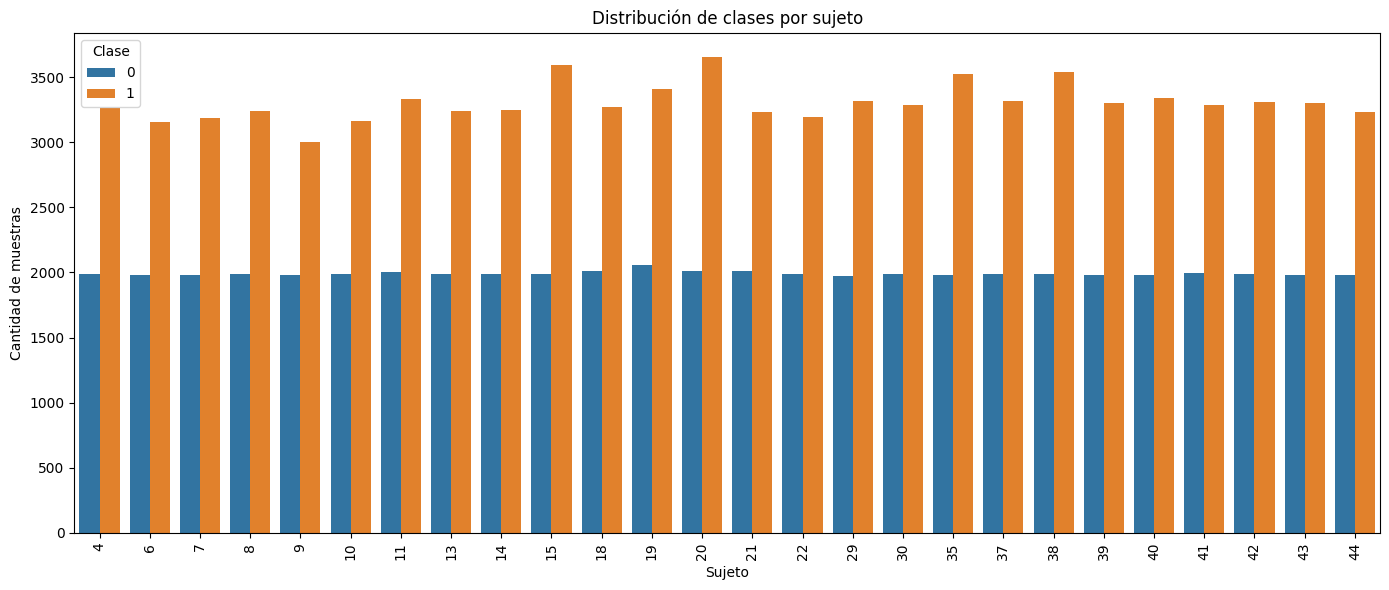

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Asegurar que son arrays 1D
subjects_flat = np.ravel(subjects_filtrados)
y_flat = np.ravel(y_filtrado)

# Crear DataFrame temporal para análisis
df_temp = pd.DataFrame({
    'subject': subjects_flat,
    'label': y_flat
})

# Contar clases por sujeto
counts = df_temp.groupby(['subject', 'label']).size().reset_index(name='count')

# Gráfico de barras
plt.figure(figsize=(14, 6))
sns.barplot(data=counts, x='subject', y='count', hue='label')
plt.title('Distribución de clases por sujeto')
plt.xlabel('Sujeto')
plt.ylabel('Cantidad de muestras')
plt.xticks(rotation=90)
plt.legend(title='Clase')
plt.tight_layout()
plt.show()


🧪 Validando grupo 1 de 37
Clases en test (sujeto 1): {0: 396, 1: 652}
Epoch 1/50
414/414 [==============================] - 5s 3ms/step - loss: 0.6326 - accuracy: 0.6169 - val_loss: 0.5936 - val_accuracy: 0.7815

Epoch 00001: val_accuracy improved from -inf to 0.78149, saving model to modelos\mejor_modelo_1.h5
Epoch 2/50
414/414 [==============================] - 1s 3ms/step - loss: 0.5375 - accuracy: 0.7810 - val_loss: 0.4966 - val_accuracy: 0.8664

Epoch 00002: val_accuracy improved from 0.78149 to 0.86641, saving model to modelos\mejor_modelo_1.h5
Epoch 3/50
414/414 [==============================] - 1s 3ms/step - loss: 0.4580 - accuracy: 0.8407 - val_loss: 0.4224 - val_accuracy: 0.8960

Epoch 00003: val_accuracy improved from 0.86641 to 0.89599, saving model to modelos\mejor_modelo_1.h5
Epoch 4/50
414/414 [==============================] - 1s 3ms/step - loss: 0.3903 - accuracy: 0.8667 - val_loss: 0.3702 - val_accuracy: 0.8998

Epoch 00004: val_accuracy improved from 0.89599 to 0.8

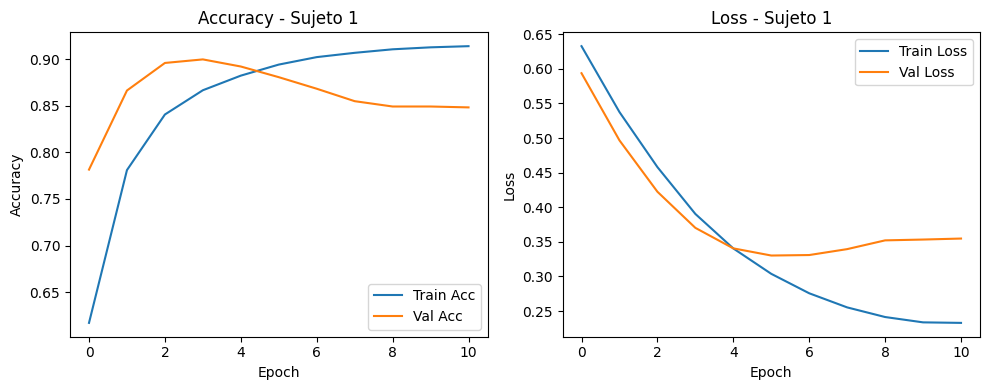

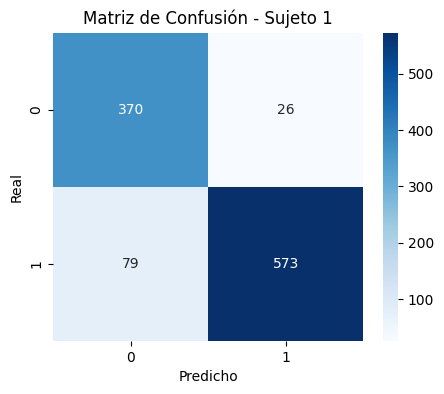

📄 Reporte de clasificación - Sujeto 1
              precision    recall  f1-score   support

           0     0.8241    0.9343    0.8757       396
           1     0.9566    0.8788    0.9161       652

    accuracy                         0.8998      1048
   macro avg     0.8903    0.9066    0.8959      1048
weighted avg     0.9065    0.8998    0.9008      1048


🧪 Validando grupo 2 de 37
Clases en test (sujeto 2): {0: 395, 1: 631}
Epoch 1/50
414/414 [==============================] - 2s 4ms/step - loss: 0.6483 - accuracy: 0.6599 - val_loss: 0.5699 - val_accuracy: 0.9181

Epoch 00001: val_accuracy improved from -inf to 0.91813, saving model to modelos\mejor_modelo_2.h5
Epoch 2/50
414/414 [==============================] - 1s 3ms/step - loss: 0.5726 - accuracy: 0.7880 - val_loss: 0.5046 - val_accuracy: 0.9425

Epoch 00002: val_accuracy improved from 0.91813 to 0.94250, saving model to modelos\mejor_modelo_2.h5
Epoch 3/50
414/414 [==============================] - 1s 3ms/step - loss: 0.5

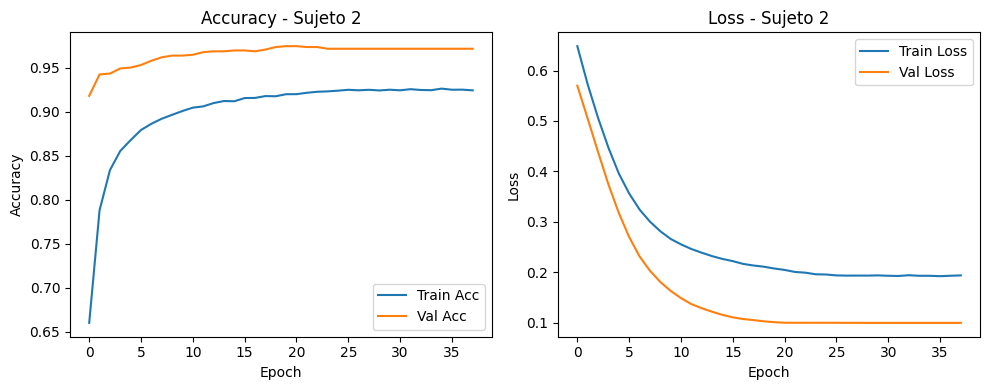

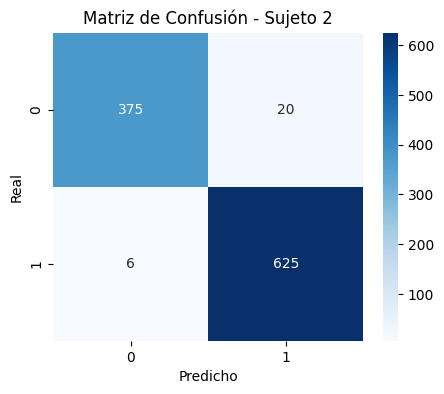

📄 Reporte de clasificación - Sujeto 2
              precision    recall  f1-score   support

           0     0.9843    0.9494    0.9665       395
           1     0.9690    0.9905    0.9796       631

    accuracy                         0.9747      1026
   macro avg     0.9766    0.9699    0.9731      1026
weighted avg     0.9749    0.9747    0.9746      1026


🧪 Validando grupo 3 de 37
Clases en test (sujeto 3): {0: 394, 1: 637}
Epoch 1/50
414/414 [==============================] - 2s 4ms/step - loss: 0.7783 - accuracy: 0.5583 - val_loss: 0.6425 - val_accuracy: 0.6712

Epoch 00001: val_accuracy improved from -inf to 0.67119, saving model to modelos\mejor_modelo_3.h5
Epoch 2/50
414/414 [==============================] - 1s 3ms/step - loss: 0.6494 - accuracy: 0.6846 - val_loss: 0.5591 - val_accuracy: 0.8167

Epoch 00002: val_accuracy improved from 0.67119 to 0.81668, saving model to modelos\mejor_modelo_3.h5
Epoch 3/50
414/414 [==============================] - 1s 3ms/step - loss: 0.5

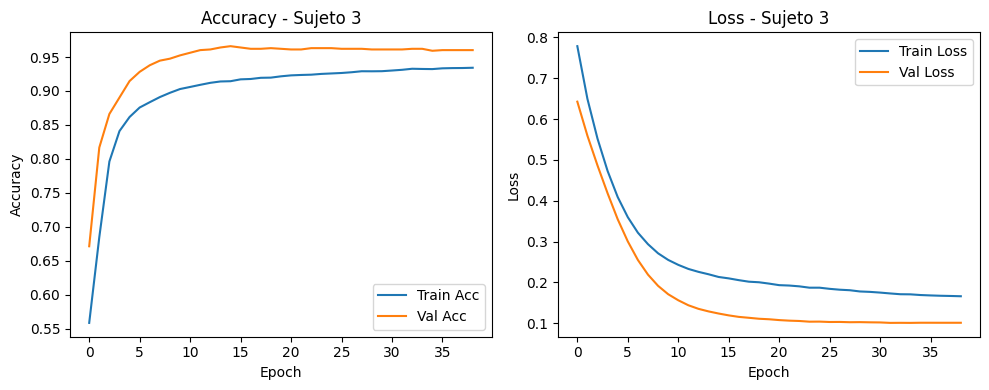

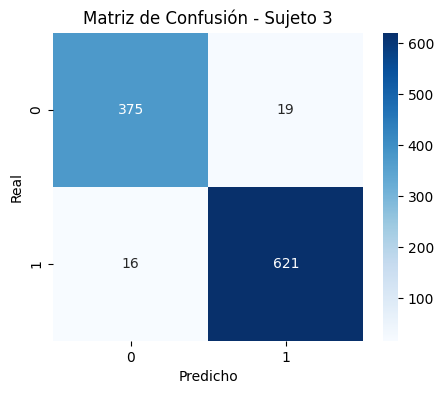

📄 Reporte de clasificación - Sujeto 3
              precision    recall  f1-score   support

           0     0.9591    0.9518    0.9554       394
           1     0.9703    0.9749    0.9726       637

    accuracy                         0.9661      1031
   macro avg     0.9647    0.9633    0.9640      1031
weighted avg     0.9660    0.9661    0.9660      1031


🧪 Validando grupo 4 de 37
Clases en test (sujeto 4): {0: 396, 1: 648}
Epoch 1/50
414/414 [==============================] - 3s 4ms/step - loss: 0.6849 - accuracy: 0.5010 - val_loss: 0.6593 - val_accuracy: 0.6216

Epoch 00001: val_accuracy improved from -inf to 0.62165, saving model to modelos\mejor_modelo_4.h5
Epoch 2/50
414/414 [==============================] - 1s 3ms/step - loss: 0.6059 - accuracy: 0.6679 - val_loss: 0.5949 - val_accuracy: 0.7251

Epoch 00002: val_accuracy improved from 0.62165 to 0.72510, saving model to modelos\mejor_modelo_4.h5
Epoch 3/50
414/414 [==============================] - 1s 3ms/step - loss: 0.5

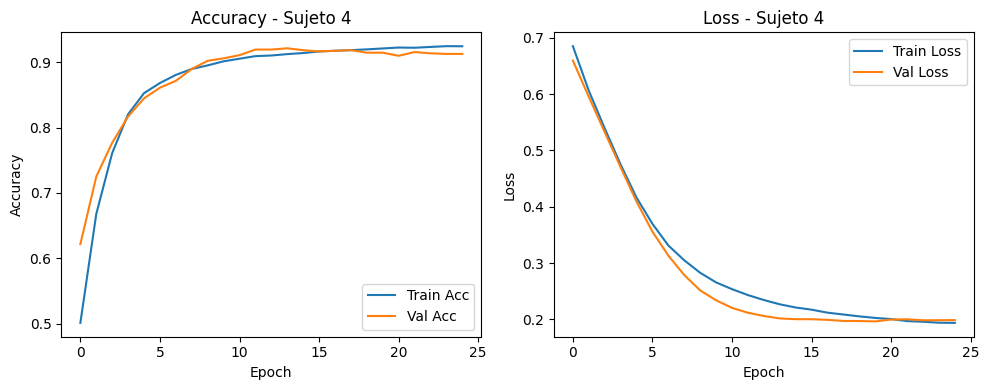

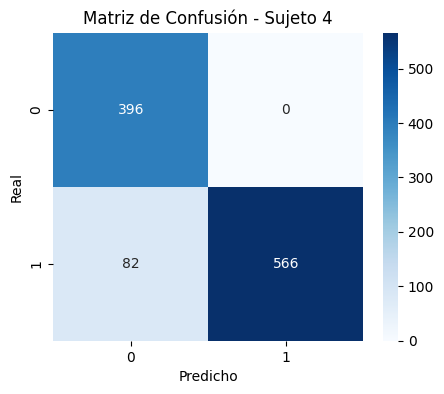

📄 Reporte de clasificación - Sujeto 4
              precision    recall  f1-score   support

           0     0.8285    1.0000    0.9062       396
           1     1.0000    0.8735    0.9325       648

    accuracy                         0.9215      1044
   macro avg     0.9142    0.9367    0.9193      1044
weighted avg     0.9349    0.9215    0.9225      1044


🧪 Validando grupo 5 de 37
Clases en test (sujeto 5): {0: 395, 1: 600}
Epoch 1/50
415/415 [==============================] - 3s 4ms/step - loss: 0.6261 - accuracy: 0.6681 - val_loss: 0.5409 - val_accuracy: 0.8452

Epoch 00001: val_accuracy improved from -inf to 0.84523, saving model to modelos\mejor_modelo_5.h5
Epoch 2/50
415/415 [==============================] - 1s 3ms/step - loss: 0.5465 - accuracy: 0.7829 - val_loss: 0.4383 - val_accuracy: 0.9146

Epoch 00002: val_accuracy improved from 0.84523 to 0.91457, saving model to modelos\mejor_modelo_5.h5
Epoch 3/50
415/415 [==============================] - 1s 3ms/step - loss: 0.4

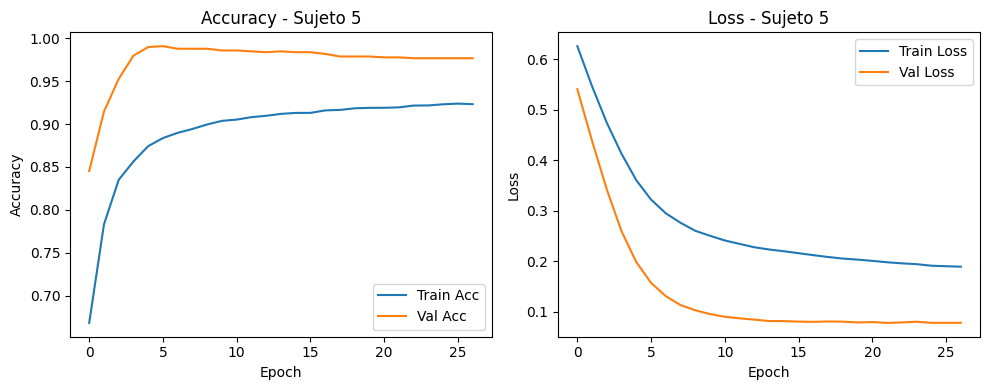

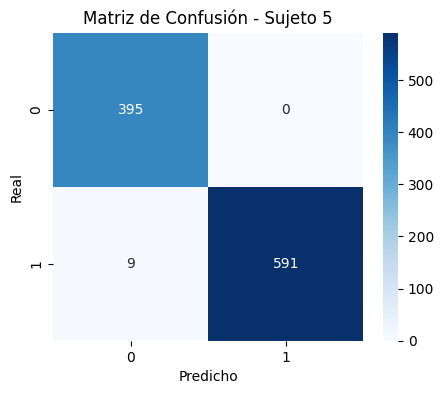

📄 Reporte de clasificación - Sujeto 5
              precision    recall  f1-score   support

           0     0.9777    1.0000    0.9887       395
           1     1.0000    0.9850    0.9924       600

    accuracy                         0.9910       995
   macro avg     0.9889    0.9925    0.9906       995
weighted avg     0.9912    0.9910    0.9910       995


🧪 Validando grupo 6 de 37
Clases en test (sujeto 6): {0: 396, 1: 632}
Epoch 1/50
414/414 [==============================] - 2s 4ms/step - loss: 0.6293 - accuracy: 0.5919 - val_loss: 0.6316 - val_accuracy: 0.6751

Epoch 00001: val_accuracy improved from -inf to 0.67510, saving model to modelos\mejor_modelo_6.h5
Epoch 2/50
414/414 [==============================] - 1s 3ms/step - loss: 0.5480 - accuracy: 0.7543 - val_loss: 0.5748 - val_accuracy: 0.7296

Epoch 00002: val_accuracy improved from 0.67510 to 0.72957, saving model to modelos\mejor_modelo_6.h5
Epoch 3/50
414/414 [==============================] - 1s 3ms/step - loss: 0.4

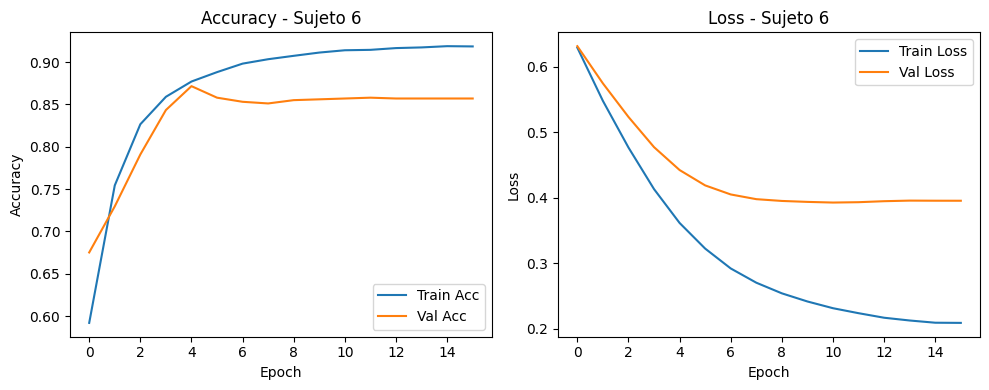

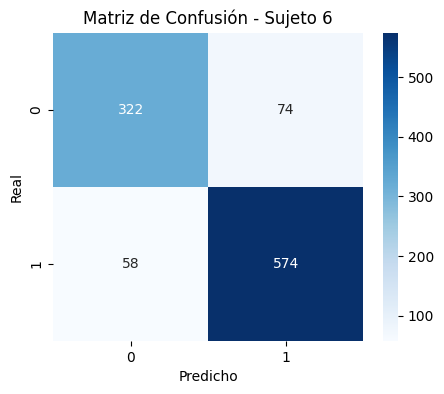

📄 Reporte de clasificación - Sujeto 6
              precision    recall  f1-score   support

           0     0.8474    0.8131    0.8299       396
           1     0.8858    0.9082    0.8969       632

    accuracy                         0.8716      1028
   macro avg     0.8666    0.8607    0.8634      1028
weighted avg     0.8710    0.8716    0.8711      1028


🧪 Validando grupo 7 de 37
Clases en test (sujeto 7): {0: 399, 1: 666}
Epoch 1/50
414/414 [==============================] - 2s 4ms/step - loss: 0.6431 - accuracy: 0.5437 - val_loss: 0.5942 - val_accuracy: 0.6892

Epoch 00001: val_accuracy improved from -inf to 0.68920, saving model to modelos\mejor_modelo_7.h5
Epoch 2/50
414/414 [==============================] - 1s 3ms/step - loss: 0.5481 - accuracy: 0.7329 - val_loss: 0.4771 - val_accuracy: 0.9005

Epoch 00002: val_accuracy improved from 0.68920 to 0.90047, saving model to modelos\mejor_modelo_7.h5
Epoch 3/50
414/414 [==============================] - 1s 3ms/step - loss: 0.4

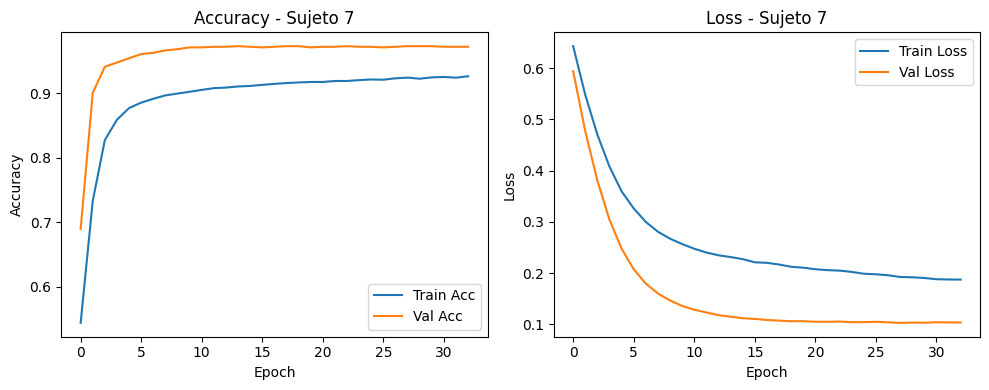

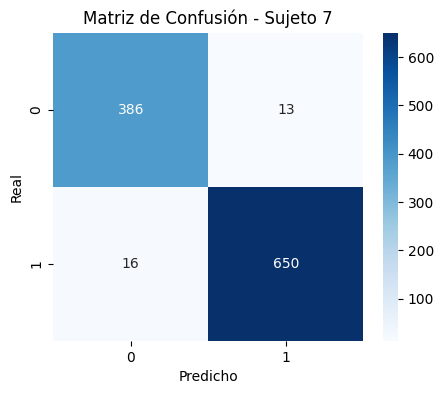

📄 Reporte de clasificación - Sujeto 7
              precision    recall  f1-score   support

           0     0.9602    0.9674    0.9638       399
           1     0.9804    0.9760    0.9782       666

    accuracy                         0.9728      1065
   macro avg     0.9703    0.9717    0.9710      1065
weighted avg     0.9728    0.9728    0.9728      1065


🧪 Validando grupo 8 de 37
Clases en test (sujeto 8): {0: 396, 1: 647}
Epoch 1/50
414/414 [==============================] - 2s 4ms/step - loss: 0.6640 - accuracy: 0.6339 - val_loss: 0.5990 - val_accuracy: 0.8082

Epoch 00001: val_accuracy improved from -inf to 0.80825, saving model to modelos\mejor_modelo_8.h5
Epoch 2/50
414/414 [==============================] - 1s 3ms/step - loss: 0.5868 - accuracy: 0.7649 - val_loss: 0.5192 - val_accuracy: 0.8322

Epoch 00002: val_accuracy improved from 0.80825 to 0.83221, saving model to modelos\mejor_modelo_8.h5
Epoch 3/50
414/414 [==============================] - 1s 3ms/step - loss: 0.5

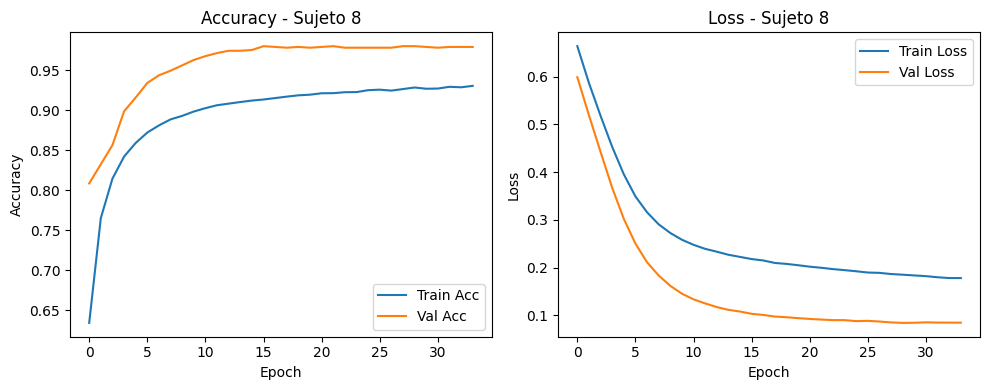

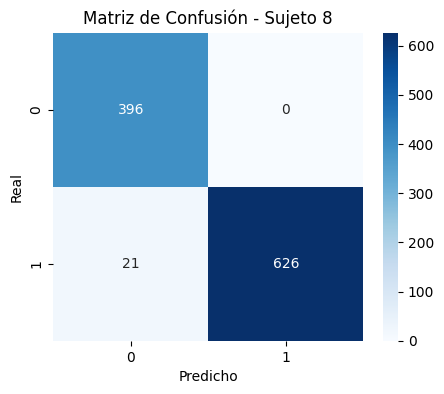

📄 Reporte de clasificación - Sujeto 8
              precision    recall  f1-score   support

           0     0.9496    1.0000    0.9742       396
           1     1.0000    0.9675    0.9835       647

    accuracy                         0.9799      1043
   macro avg     0.9748    0.9838    0.9788      1043
weighted avg     0.9809    0.9799    0.9800      1043


🧪 Validando grupo 9 de 37
Clases en test (sujeto 9): {0: 396, 1: 650}
Epoch 1/50
414/414 [==============================] - 3s 4ms/step - loss: 0.6788 - accuracy: 0.6342 - val_loss: 0.6152 - val_accuracy: 0.6855

Epoch 00001: val_accuracy improved from -inf to 0.68547, saving model to modelos\mejor_modelo_9.h5
Epoch 2/50
414/414 [==============================] - 1s 3ms/step - loss: 0.5957 - accuracy: 0.7630 - val_loss: 0.5395 - val_accuracy: 0.8413

Epoch 00002: val_accuracy improved from 0.68547 to 0.84130, saving model to modelos\mejor_modelo_9.h5
Epoch 3/50
414/414 [==============================] - 1s 3ms/step - loss: 0.5

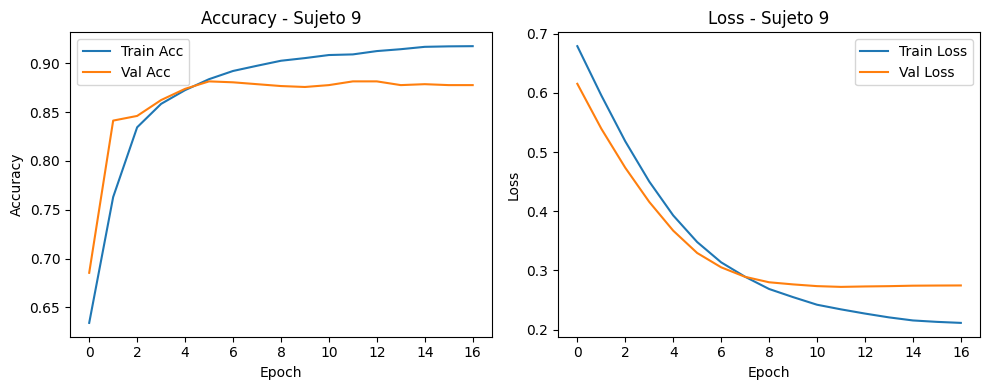

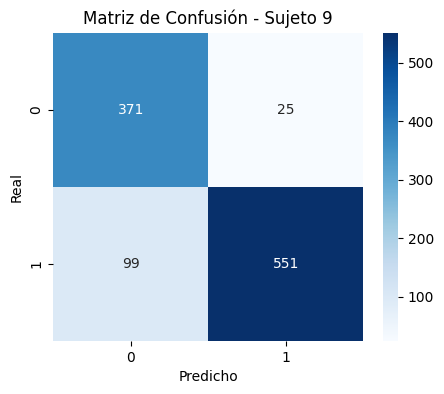

📄 Reporte de clasificación - Sujeto 9
              precision    recall  f1-score   support

           0     0.7894    0.9369    0.8568       396
           1     0.9566    0.8477    0.8989       650

    accuracy                         0.8815      1046
   macro avg     0.8730    0.8923    0.8778      1046
weighted avg     0.8933    0.8815    0.8829      1046


🧪 Validando grupo 10 de 37
Clases en test (sujeto 10): {0: 396, 1: 718}
Epoch 1/50
413/413 [==============================] - 2s 4ms/step - loss: 0.6601 - accuracy: 0.5981 - val_loss: 0.5847 - val_accuracy: 0.8043

Epoch 00001: val_accuracy improved from -inf to 0.80431, saving model to modelos\mejor_modelo_10.h5
Epoch 2/50
413/413 [==============================] - 1s 3ms/step - loss: 0.5878 - accuracy: 0.7296 - val_loss: 0.4976 - val_accuracy: 0.8905

Epoch 00002: val_accuracy improved from 0.80431 to 0.89048, saving model to modelos\mejor_modelo_10.h5
Epoch 3/50
413/413 [==============================] - 1s 3ms/step - loss:

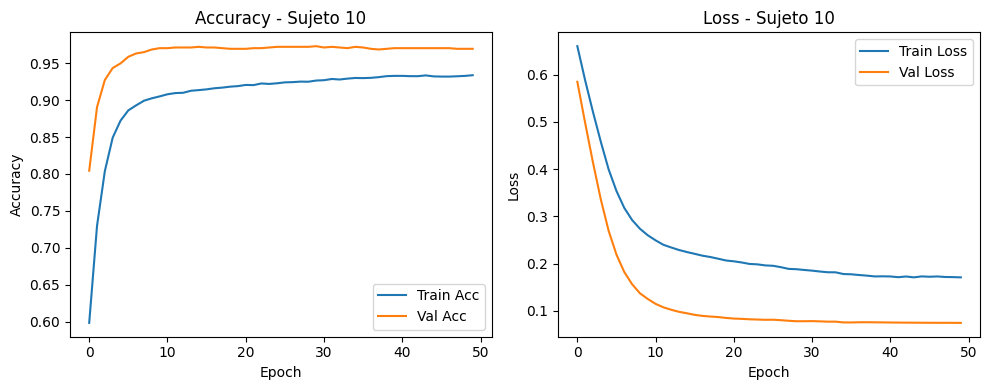

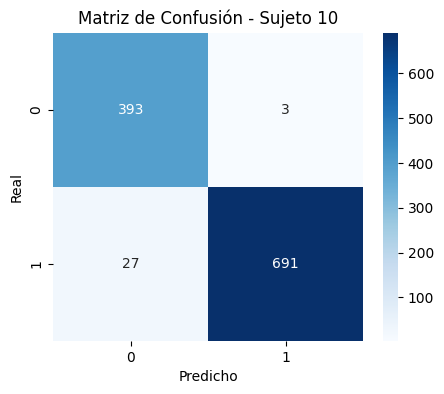

📄 Reporte de clasificación - Sujeto 10
              precision    recall  f1-score   support

           0     0.9357    0.9924    0.9632       396
           1     0.9957    0.9624    0.9788       718

    accuracy                         0.9731      1114
   macro avg     0.9657    0.9774    0.9710      1114
weighted avg     0.9744    0.9731    0.9732      1114


🧪 Validando grupo 11 de 37
Clases en test (sujeto 11): {0: 401, 1: 653}
Epoch 1/50
414/414 [==============================] - 2s 3ms/step - loss: 0.6992 - accuracy: 0.4435 - val_loss: 0.6955 - val_accuracy: 0.5455

Epoch 00001: val_accuracy improved from -inf to 0.54554, saving model to modelos\mejor_modelo_11.h5
Epoch 2/50
414/414 [==============================] - 1s 3ms/step - loss: 0.6159 - accuracy: 0.6159 - val_loss: 0.6528 - val_accuracy: 0.6300

Epoch 00002: val_accuracy improved from 0.54554 to 0.62998, saving model to modelos\mejor_modelo_11.h5
Epoch 3/50
414/414 [==============================] - 1s 3ms/step - loss

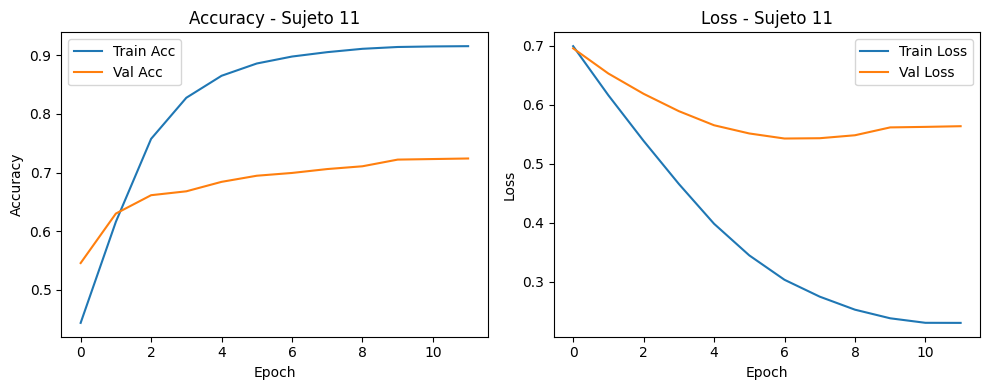

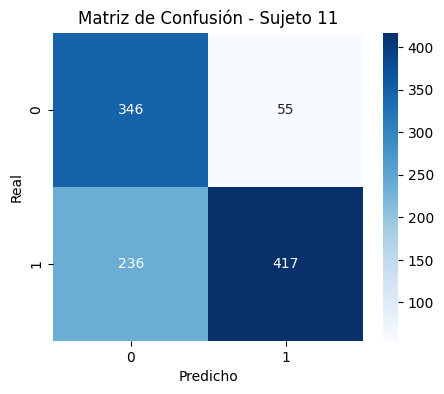

📄 Reporte de clasificación - Sujeto 11
              precision    recall  f1-score   support

           0     0.5945    0.8628    0.7040       401
           1     0.8835    0.6386    0.7413       653

    accuracy                         0.7239      1054
   macro avg     0.7390    0.7507    0.7227      1054
weighted avg     0.7735    0.7239    0.7271      1054


🧪 Validando grupo 12 de 37
Clases en test (sujeto 12): {0: 410, 1: 682}
Epoch 1/50
413/413 [==============================] - 2s 3ms/step - loss: 0.6975 - accuracy: 0.5037 - val_loss: 0.5408 - val_accuracy: 0.8278

Epoch 00001: val_accuracy improved from -inf to 0.82784, saving model to modelos\mejor_modelo_12.h5
Epoch 2/50
413/413 [==============================] - 1s 3ms/step - loss: 0.5959 - accuracy: 0.6802 - val_loss: 0.4093 - val_accuracy: 0.9707

Epoch 00002: val_accuracy improved from 0.82784 to 0.97070, saving model to modelos\mejor_modelo_12.h5
Epoch 3/50
413/413 [==============================] - 1s 3ms/step - loss

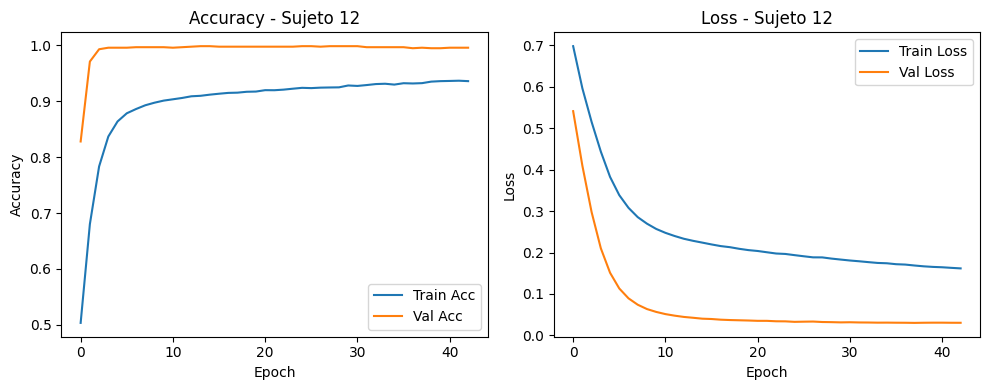

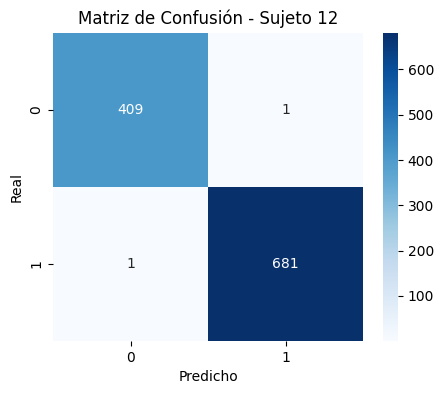

📄 Reporte de clasificación - Sujeto 12
              precision    recall  f1-score   support

           0     0.9976    0.9976    0.9976       410
           1     0.9985    0.9985    0.9985       682

    accuracy                         0.9982      1092
   macro avg     0.9980    0.9980    0.9980      1092
weighted avg     0.9982    0.9982    0.9982      1092


🧪 Validando grupo 13 de 37
Clases en test (sujeto 13): {0: 400, 1: 732}
Epoch 1/50
413/413 [==============================] - 2s 4ms/step - loss: 0.6458 - accuracy: 0.6234 - val_loss: 0.5586 - val_accuracy: 0.8489

Epoch 00001: val_accuracy improved from -inf to 0.84894, saving model to modelos\mejor_modelo_13.h5
Epoch 2/50
413/413 [==============================] - 1s 3ms/step - loss: 0.5644 - accuracy: 0.7518 - val_loss: 0.4662 - val_accuracy: 0.9549

Epoch 00002: val_accuracy improved from 0.84894 to 0.95495, saving model to modelos\mejor_modelo_13.h5
Epoch 3/50
413/413 [==============================] - 1s 3ms/step - loss

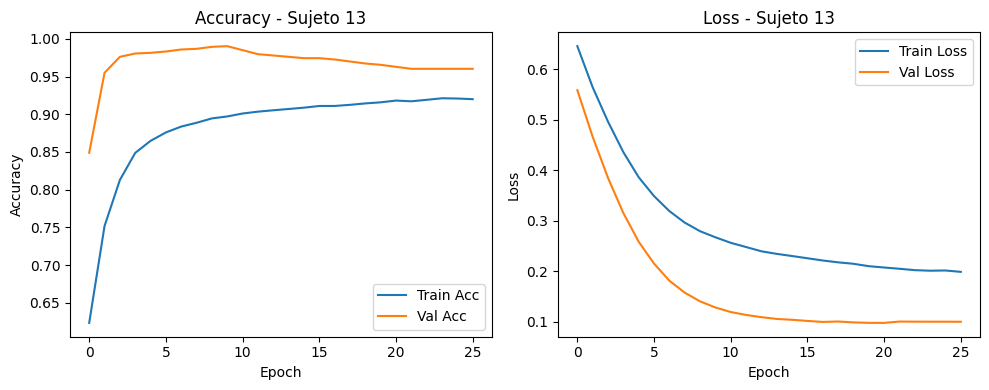

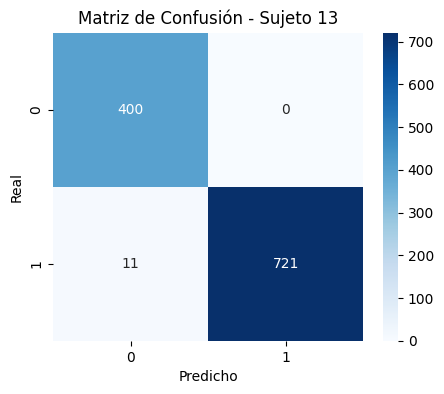

📄 Reporte de clasificación - Sujeto 13
              precision    recall  f1-score   support

           0     0.9732    1.0000    0.9864       400
           1     1.0000    0.9850    0.9924       732

    accuracy                         0.9903      1132
   macro avg     0.9866    0.9925    0.9894      1132
weighted avg     0.9905    0.9903    0.9903      1132


🧪 Validando grupo 14 de 37
Clases en test (sujeto 14): {0: 401, 1: 647}
Epoch 1/50
414/414 [==============================] - 2s 4ms/step - loss: 0.6673 - accuracy: 0.5909 - val_loss: 0.5751 - val_accuracy: 0.8397

Epoch 00001: val_accuracy improved from -inf to 0.83969, saving model to modelos\mejor_modelo_14.h5
Epoch 2/50
414/414 [==============================] - 1s 3ms/step - loss: 0.5860 - accuracy: 0.7488 - val_loss: 0.4789 - val_accuracy: 0.9485

Epoch 00002: val_accuracy improved from 0.83969 to 0.94847, saving model to modelos\mejor_modelo_14.h5
Epoch 3/50
414/414 [==============================] - 1s 3ms/step - loss

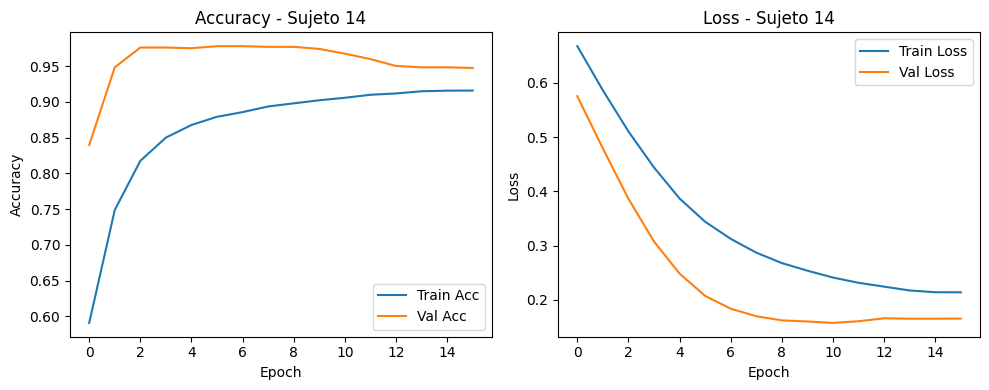

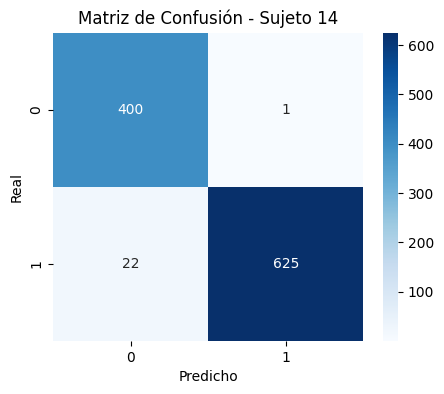

📄 Reporte de clasificación - Sujeto 14
              precision    recall  f1-score   support

           0     0.9479    0.9975    0.9721       401
           1     0.9984    0.9660    0.9819       647

    accuracy                         0.9781      1048
   macro avg     0.9731    0.9818    0.9770      1048
weighted avg     0.9791    0.9781    0.9782      1048


🧪 Validando grupo 15 de 37
Clases en test (sujeto 15): {0: 397, 1: 638}
Epoch 1/50
414/414 [==============================] - 3s 4ms/step - loss: 0.7009 - accuracy: 0.4542 - val_loss: 0.6615 - val_accuracy: 0.5275

Epoch 00001: val_accuracy improved from -inf to 0.52754, saving model to modelos\mejor_modelo_15.h5
Epoch 2/50
414/414 [==============================] - 1s 3ms/step - loss: 0.6011 - accuracy: 0.6345 - val_loss: 0.5318 - val_accuracy: 0.7845

Epoch 00002: val_accuracy improved from 0.52754 to 0.78454, saving model to modelos\mejor_modelo_15.h5
Epoch 3/50
414/414 [==============================] - 1s 3ms/step - loss

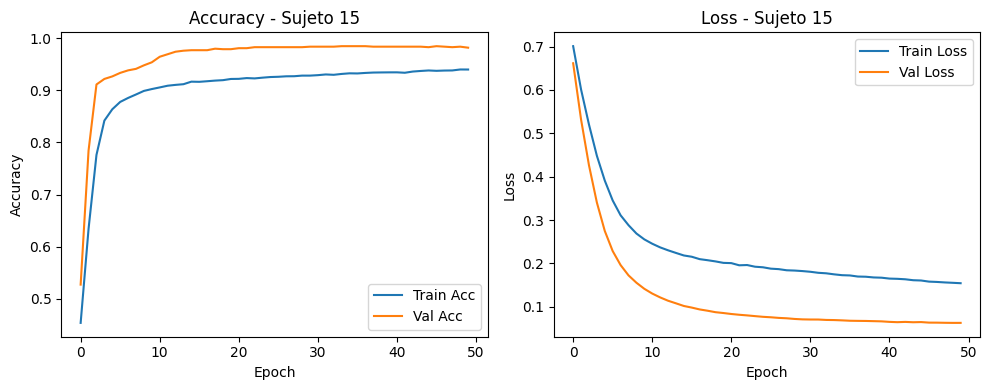

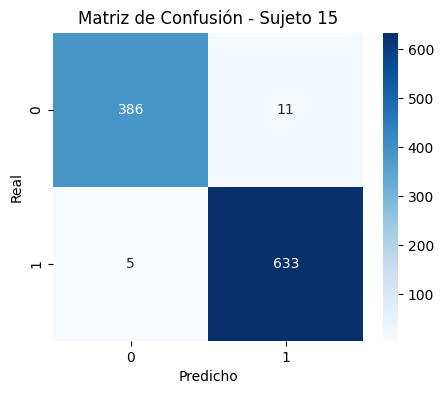

📄 Reporte de clasificación - Sujeto 15
              precision    recall  f1-score   support

           0     0.9872    0.9723    0.9797       397
           1     0.9829    0.9922    0.9875       638

    accuracy                         0.9845      1035
   macro avg     0.9851    0.9822    0.9836      1035
weighted avg     0.9846    0.9845    0.9845      1035


🧪 Validando grupo 16 de 37
Clases en test (sujeto 16): {0: 393, 1: 664}
Epoch 1/50
414/414 [==============================] - 3s 4ms/step - loss: 0.6273 - accuracy: 0.6557 - val_loss: 0.7555 - val_accuracy: 0.4551

Epoch 00001: val_accuracy improved from -inf to 0.45506, saving model to modelos\mejor_modelo_16.h5
Epoch 2/50
414/414 [==============================] - 1s 3ms/step - loss: 0.5373 - accuracy: 0.7702 - val_loss: 0.7809 - val_accuracy: 0.4711

Epoch 00002: val_accuracy improved from 0.45506 to 0.47114, saving model to modelos\mejor_modelo_16.h5
Epoch 3/50
414/414 [==============================] - 1s 3ms/step - loss

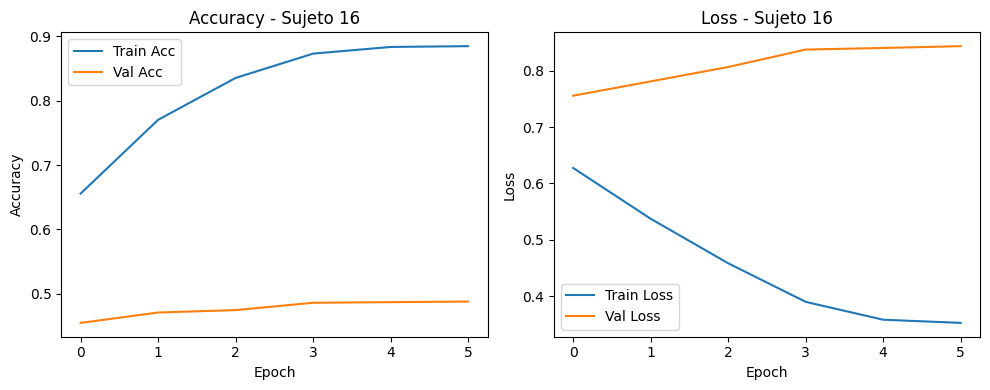

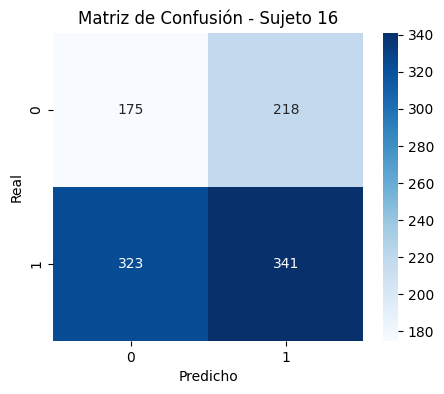

📄 Reporte de clasificación - Sujeto 16
              precision    recall  f1-score   support

           0     0.3514    0.4453    0.3928       393
           1     0.6100    0.5136    0.5576       664

    accuracy                         0.4882      1057
   macro avg     0.4807    0.4794    0.4752      1057
weighted avg     0.5139    0.4882    0.4964      1057


🧪 Validando grupo 17 de 37
Clases en test (sujeto 17): {0: 396, 1: 658}
Epoch 1/50
414/414 [==============================] - 2s 3ms/step - loss: 0.6628 - accuracy: 0.5981 - val_loss: 0.6259 - val_accuracy: 0.6357

Epoch 00001: val_accuracy improved from -inf to 0.63567, saving model to modelos\mejor_modelo_17.h5
Epoch 2/50
414/414 [==============================] - 1s 3ms/step - loss: 0.5801 - accuracy: 0.7288 - val_loss: 0.5366 - val_accuracy: 0.7609

Epoch 00002: val_accuracy improved from 0.63567 to 0.76091, saving model to modelos\mejor_modelo_17.h5
Epoch 3/50
414/414 [==============================] - 1s 3ms/step - loss

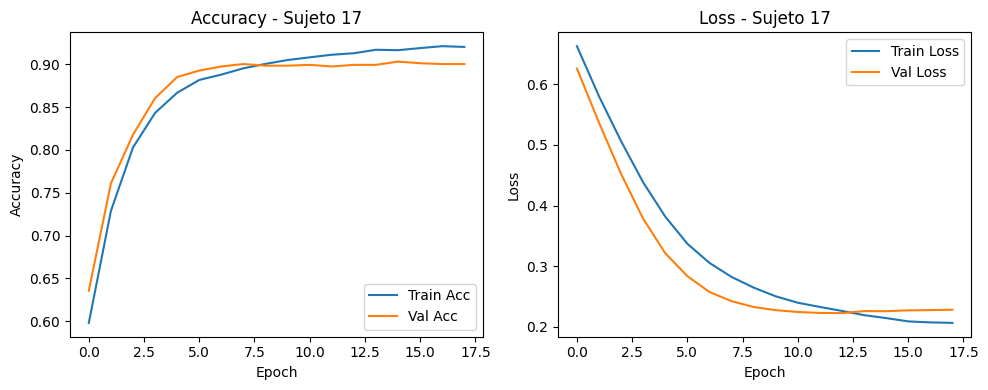

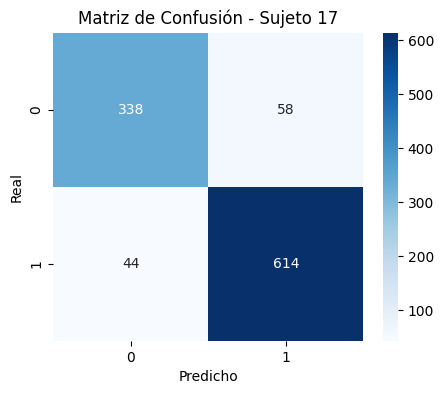

📄 Reporte de clasificación - Sujeto 17
              precision    recall  f1-score   support

           0     0.8848    0.8535    0.8689       396
           1     0.9137    0.9331    0.9233       658

    accuracy                         0.9032      1054
   macro avg     0.8993    0.8933    0.8961      1054
weighted avg     0.9028    0.9032    0.9029      1054


🧪 Validando grupo 18 de 37
Clases en test (sujeto 18): {0: 395, 1: 705}
Epoch 1/50
413/413 [==============================] - 2s 4ms/step - loss: 0.6626 - accuracy: 0.5573 - val_loss: 0.6323 - val_accuracy: 0.6382

Epoch 00001: val_accuracy improved from -inf to 0.63818, saving model to modelos\mejor_modelo_18.h5
Epoch 2/50
413/413 [==============================] - 1s 3ms/step - loss: 0.5784 - accuracy: 0.7068 - val_loss: 0.6012 - val_accuracy: 0.6655

Epoch 00002: val_accuracy improved from 0.63818 to 0.66545, saving model to modelos\mejor_modelo_18.h5
Epoch 3/50
413/413 [==============================] - 1s 3ms/step - loss

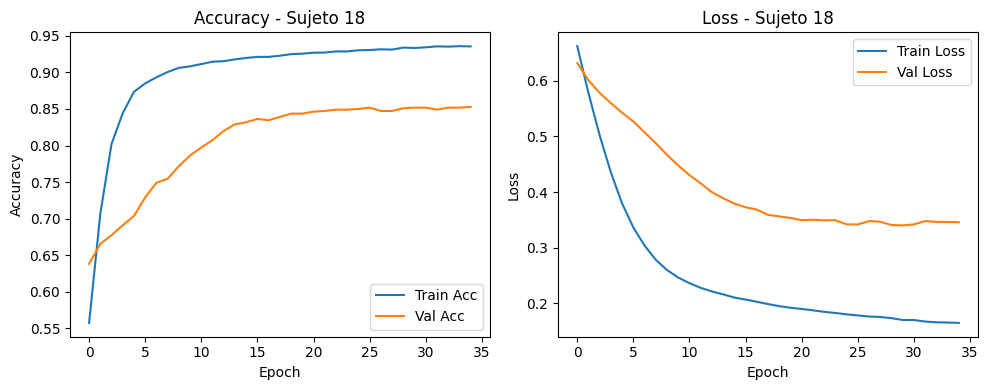

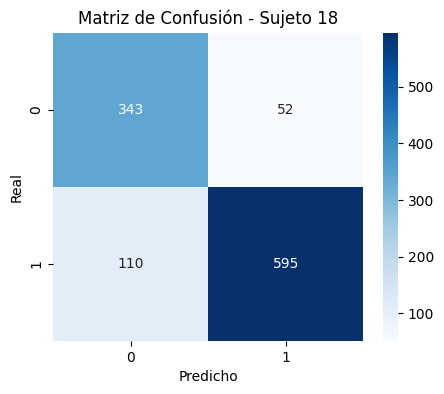

📄 Reporte de clasificación - Sujeto 18
              precision    recall  f1-score   support

           0     0.7572    0.8684    0.8090       395
           1     0.9196    0.8440    0.8802       705

    accuracy                         0.8527      1100
   macro avg     0.8384    0.8562    0.8446      1100
weighted avg     0.8613    0.8527    0.8546      1100


🧪 Validando grupo 19 de 37
Clases en test (sujeto 19): {0: 396, 1: 663}
Epoch 1/50
414/414 [==============================] - 2s 4ms/step - loss: 0.6373 - accuracy: 0.6532 - val_loss: 0.7319 - val_accuracy: 0.5260

Epoch 00001: val_accuracy improved from -inf to 0.52597, saving model to modelos\mejor_modelo_19.h5
Epoch 2/50
414/414 [==============================] - 1s 3ms/step - loss: 0.5462 - accuracy: 0.7699 - val_loss: 0.7272 - val_accuracy: 0.5656

Epoch 00002: val_accuracy improved from 0.52597 to 0.56563, saving model to modelos\mejor_modelo_19.h5
Epoch 3/50
414/414 [==============================] - 1s 3ms/step - loss

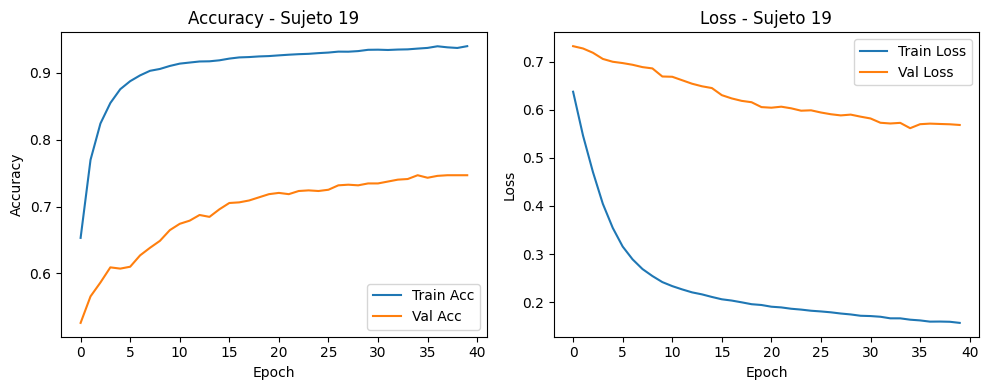

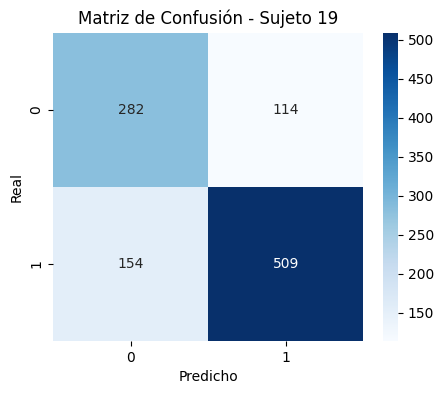

📄 Reporte de clasificación - Sujeto 19
              precision    recall  f1-score   support

           0     0.6468    0.7121    0.6779       396
           1     0.8170    0.7677    0.7916       663

    accuracy                         0.7469      1059
   macro avg     0.7319    0.7399    0.7347      1059
weighted avg     0.7534    0.7469    0.7491      1059


🧪 Validando grupo 20 de 37
Clases en test (sujeto 20): {0: 396, 1: 707}
Epoch 1/50
413/413 [==============================] - 2s 4ms/step - loss: 0.6564 - accuracy: 0.5972 - val_loss: 0.5608 - val_accuracy: 0.8141

Epoch 00001: val_accuracy improved from -inf to 0.81414, saving model to modelos\mejor_modelo_20.h5
Epoch 2/50
413/413 [==============================] - 1s 3ms/step - loss: 0.5707 - accuracy: 0.7504 - val_loss: 0.4681 - val_accuracy: 0.9057

Epoch 00002: val_accuracy improved from 0.81414 to 0.90571, saving model to modelos\mejor_modelo_20.h5
Epoch 3/50
413/413 [==============================] - 1s 3ms/step - loss

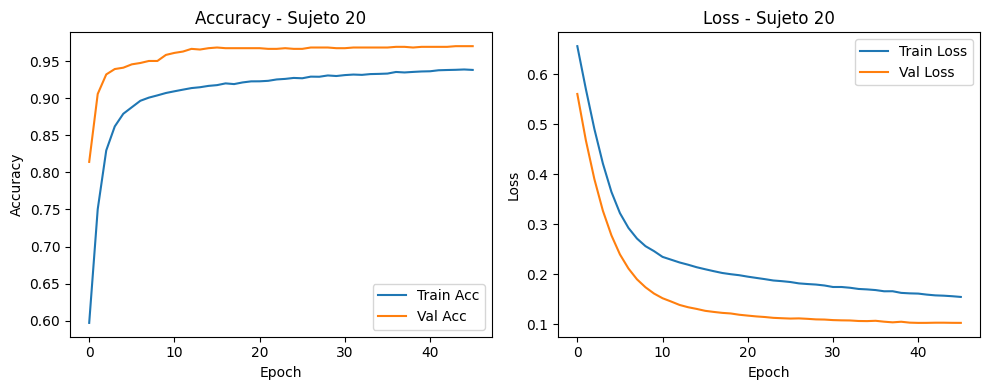

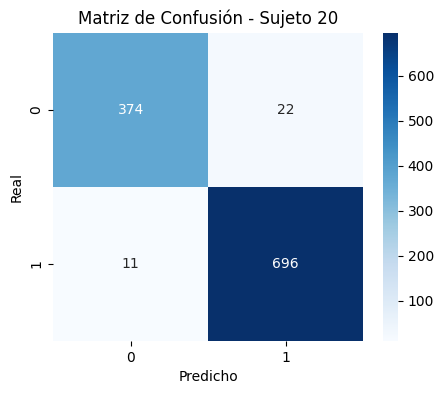

📄 Reporte de clasificación - Sujeto 20
              precision    recall  f1-score   support

           0     0.9714    0.9444    0.9577       396
           1     0.9694    0.9844    0.9768       707

    accuracy                         0.9701      1103
   macro avg     0.9704    0.9644    0.9673      1103
weighted avg     0.9701    0.9701    0.9700      1103


🧪 Validando grupo 21 de 37
Clases en test (sujeto 21): {0: 395, 1: 661}
Epoch 1/50
414/414 [==============================] - 2s 4ms/step - loss: 0.6520 - accuracy: 0.6803 - val_loss: 0.5801 - val_accuracy: 0.8788

Epoch 00001: val_accuracy improved from -inf to 0.87879, saving model to modelos\mejor_modelo_21.h5
Epoch 2/50
414/414 [==============================] - 1s 3ms/step - loss: 0.5781 - accuracy: 0.7905 - val_loss: 0.5208 - val_accuracy: 0.8996

Epoch 00002: val_accuracy improved from 0.87879 to 0.89962, saving model to modelos\mejor_modelo_21.h5
Epoch 3/50
414/414 [==============================] - 1s 3ms/step - loss

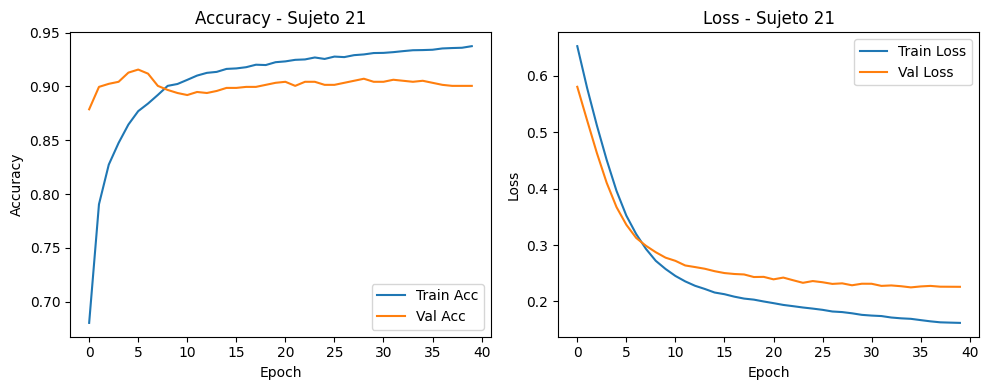

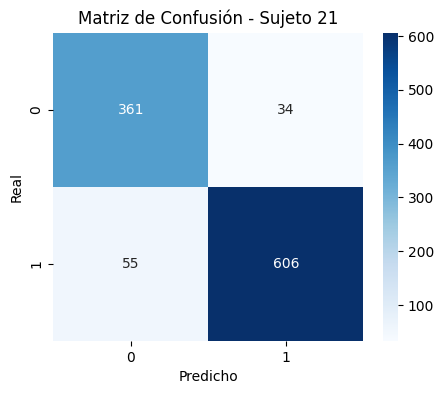

📄 Reporte de clasificación - Sujeto 21
              precision    recall  f1-score   support

           0     0.8678    0.9139    0.8903       395
           1     0.9469    0.9168    0.9316       661

    accuracy                         0.9157      1056
   macro avg     0.9073    0.9154    0.9109      1056
weighted avg     0.9173    0.9157    0.9161      1056


🧪 Validando grupo 22 de 37
Clases en test (sujeto 22): {0: 395, 1: 668}
Epoch 1/50
414/414 [==============================] - 2s 3ms/step - loss: 0.6757 - accuracy: 0.6483 - val_loss: 0.5837 - val_accuracy: 0.8777

Epoch 00001: val_accuracy improved from -inf to 0.87770, saving model to modelos\mejor_modelo_22.h5
Epoch 2/50
414/414 [==============================] - 1s 3ms/step - loss: 0.5997 - accuracy: 0.7793 - val_loss: 0.5117 - val_accuracy: 0.9426

Epoch 00002: val_accuracy improved from 0.87770 to 0.94262, saving model to modelos\mejor_modelo_22.h5
Epoch 3/50
414/414 [==============================] - 1s 3ms/step - loss

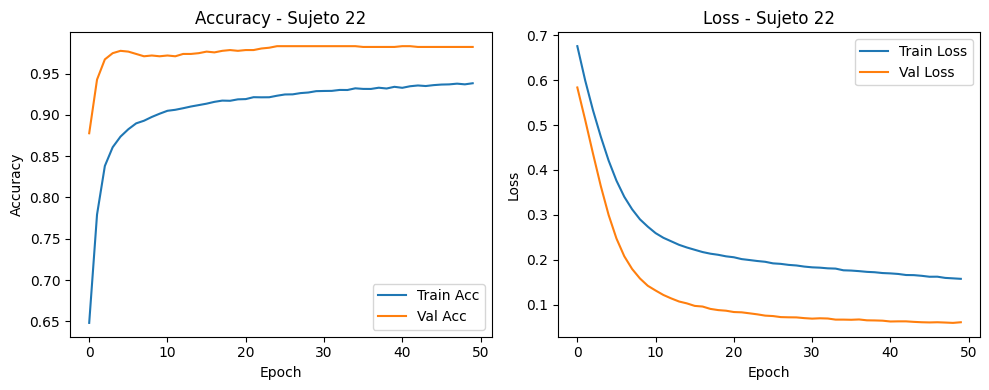

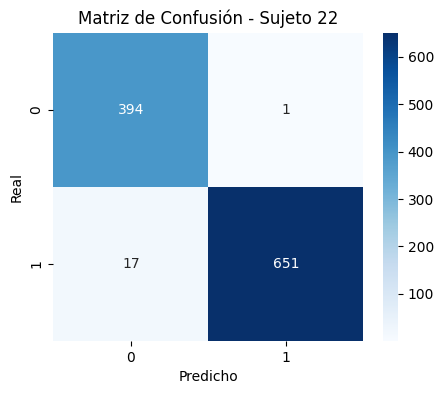

📄 Reporte de clasificación - Sujeto 22
              precision    recall  f1-score   support

           0     0.9586    0.9975    0.9777       395
           1     0.9985    0.9746    0.9864       668

    accuracy                         0.9831      1063
   macro avg     0.9786    0.9860    0.9820      1063
weighted avg     0.9837    0.9831    0.9831      1063


🧪 Validando grupo 23 de 37
Clases en test (sujeto 23): {0: 398, 1: 658}
Epoch 1/50
414/414 [==============================] - 2s 4ms/step - loss: 0.6912 - accuracy: 0.5982 - val_loss: 0.6383 - val_accuracy: 0.6903

Epoch 00001: val_accuracy improved from -inf to 0.69034, saving model to modelos\mejor_modelo_23.h5
Epoch 2/50
414/414 [==============================] - 1s 3ms/step - loss: 0.6167 - accuracy: 0.7392 - val_loss: 0.5444 - val_accuracy: 0.8731

Epoch 00002: val_accuracy improved from 0.69034 to 0.87311, saving model to modelos\mejor_modelo_23.h5
Epoch 3/50
414/414 [==============================] - 1s 3ms/step - loss

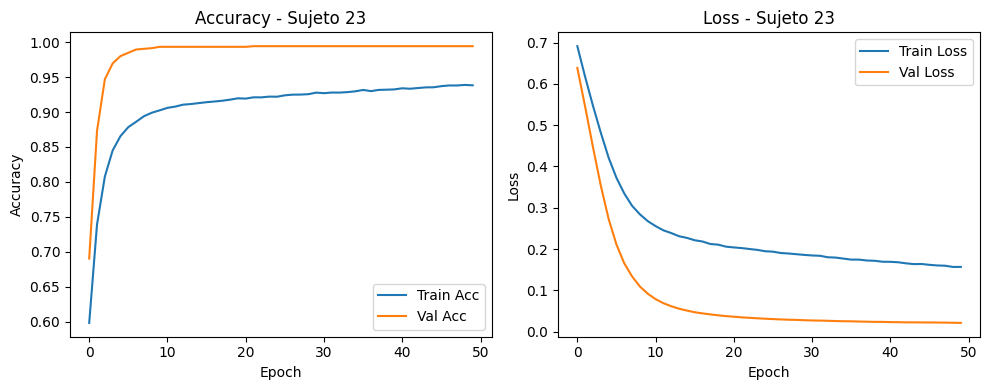

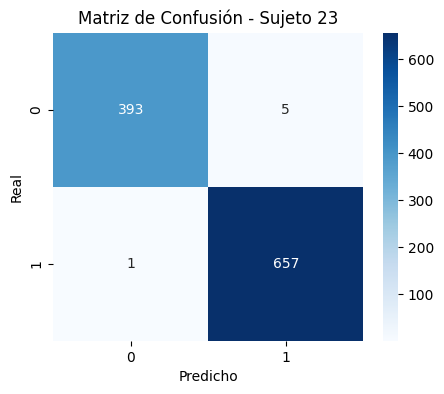

📄 Reporte de clasificación - Sujeto 23
              precision    recall  f1-score   support

           0     0.9975    0.9874    0.9924       398
           1     0.9924    0.9985    0.9955       658

    accuracy                         0.9943      1056
   macro avg     0.9950    0.9930    0.9939      1056
weighted avg     0.9943    0.9943    0.9943      1056


🧪 Validando grupo 24 de 37
Clases en test (sujeto 24): {0: 396, 1: 663}
Epoch 1/50
414/414 [==============================] - 2s 3ms/step - loss: 0.6452 - accuracy: 0.6969 - val_loss: 0.6464 - val_accuracy: 0.6516

Epoch 00001: val_accuracy improved from -inf to 0.65156, saving model to modelos\mejor_modelo_24.h5
Epoch 2/50
414/414 [==============================] - 1s 3ms/step - loss: 0.5500 - accuracy: 0.8151 - val_loss: 0.6650 - val_accuracy: 0.5770

Epoch 00002: val_accuracy did not improve from 0.65156
Epoch 3/50
414/414 [==============================] - 1s 3ms/step - loss: 0.4731 - accuracy: 0.8525 - val_loss: 0.6749 -

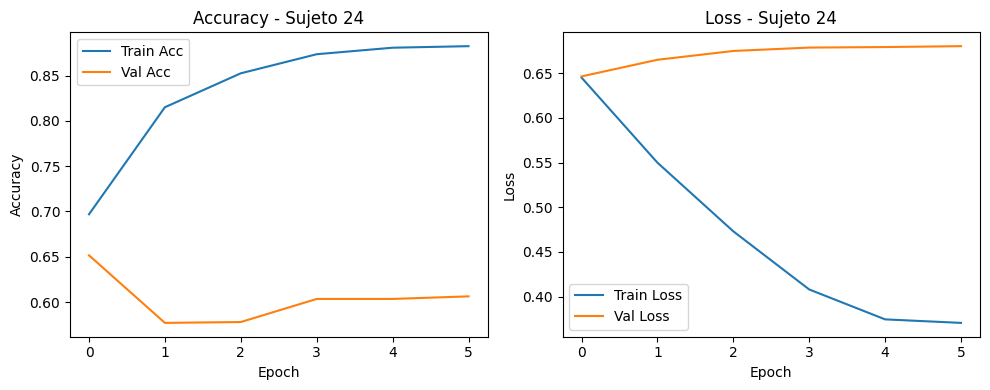

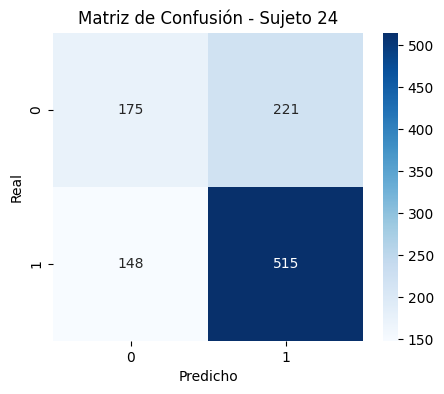

📄 Reporte de clasificación - Sujeto 24
              precision    recall  f1-score   support

           0     0.5418    0.4419    0.4868       396
           1     0.6997    0.7768    0.7362       663

    accuracy                         0.6516      1059
   macro avg     0.6208    0.6093    0.6115      1059
weighted avg     0.6407    0.6516    0.6430      1059


🧪 Validando grupo 25 de 37
Clases en test (sujeto 25): {0: 395, 1: 661}
Epoch 1/50
414/414 [==============================] - 2s 3ms/step - loss: 0.6786 - accuracy: 0.6033 - val_loss: 0.6655 - val_accuracy: 0.6032

Epoch 00001: val_accuracy improved from -inf to 0.60322, saving model to modelos\mejor_modelo_25.h5
Epoch 2/50
414/414 [==============================] - 1s 3ms/step - loss: 0.5883 - accuracy: 0.7571 - val_loss: 0.6161 - val_accuracy: 0.6941

Epoch 00002: val_accuracy improved from 0.60322 to 0.69413, saving model to modelos\mejor_modelo_25.h5
Epoch 3/50
414/414 [==============================] - 1s 3ms/step - loss

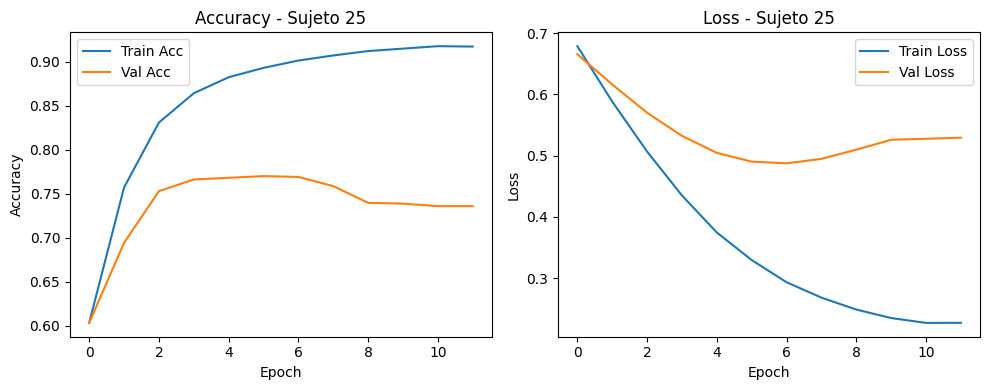

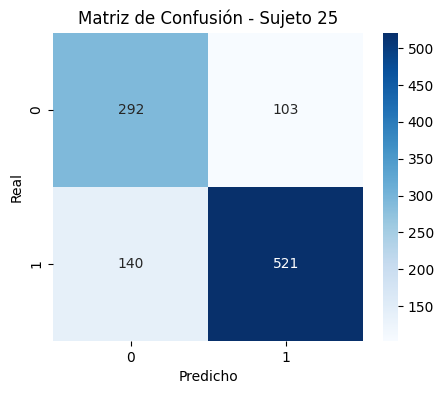

📄 Reporte de clasificación - Sujeto 25
              precision    recall  f1-score   support

           0     0.6759    0.7392    0.7062       395
           1     0.8349    0.7882    0.8109       661

    accuracy                         0.7699      1056
   macro avg     0.7554    0.7637    0.7585      1056
weighted avg     0.7755    0.7699    0.7717      1056


🧪 Validando grupo 26 de 37
Clases en test (sujeto 26): {0: 395, 1: 647}
Epoch 1/50
414/414 [==============================] - 2s 3ms/step - loss: 0.6323 - accuracy: 0.7142 - val_loss: 0.5519 - val_accuracy: 0.8532

Epoch 00001: val_accuracy improved from -inf to 0.85317, saving model to modelos\mejor_modelo_26.h5
Epoch 2/50
414/414 [==============================] - 1s 3ms/step - loss: 0.5593 - accuracy: 0.7893 - val_loss: 0.4842 - val_accuracy: 0.8935

Epoch 00002: val_accuracy improved from 0.85317 to 0.89347, saving model to modelos\mejor_modelo_26.h5
Epoch 3/50
414/414 [==============================] - 1s 3ms/step - loss

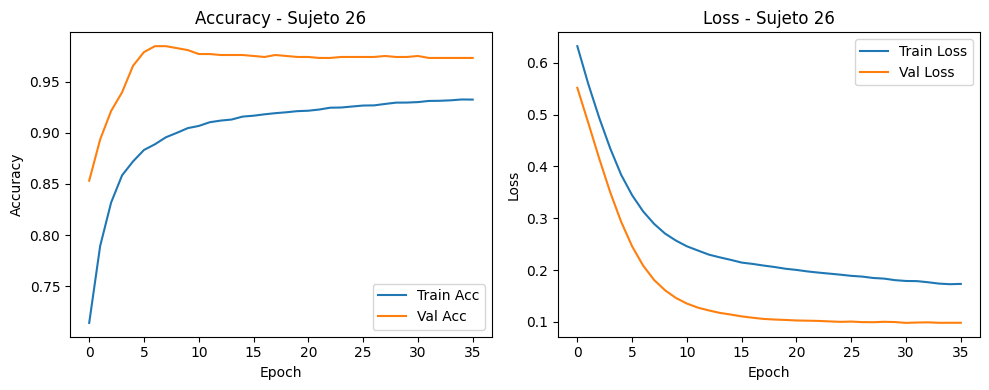

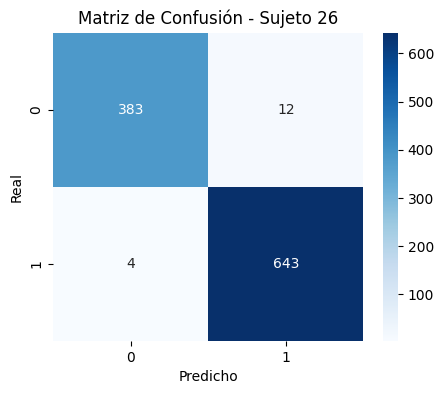

📄 Reporte de clasificación - Sujeto 26
              precision    recall  f1-score   support

           0     0.9897    0.9696    0.9795       395
           1     0.9817    0.9938    0.9877       647

    accuracy                         0.9846      1042
   macro avg     0.9857    0.9817    0.9836      1042
weighted avg     0.9847    0.9846    0.9846      1042


📊 Resultados Finales:
Promedio Accuracy: 0.8987 ± 0.1242
Promedio F1 Score: 0.9157 ± 0.1052

🔍 Análisis Train vs Val:
Diferencia promedio (Val - Train): -0.0367 ± 0.1162
Folds donde Val > Train: 14/26


In [13]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Conv1D, MaxPooling1D

accuracies = []
f1_scores = []
train_val_diffs = []  # 🆕 Para analizar diferencias

logo = LeaveOneGroupOut()
split_num = 1

for train_idx, test_idx in logo.split(X_seq, y_seq, groups=subj_seq):
    print(f"\n🧪 Validando grupo {split_num} de {len(np.unique(subjects))}")
    X_train, X_test = X_seq[train_idx], X_seq[test_idx]
    y_train, y_test = y_seq[train_idx], y_seq[test_idx]

    X_train = tf.cast(X_train, tf.float32)
    X_test = tf.cast(X_test, tf.float32)
    y_train = tf.cast(y_train, tf.int32)
    y_test = tf.cast(y_test, tf.int32)

    checkpoint = ModelCheckpoint(f"modelos/mejor_modelo_{split_num}.h5", monitor="val_accuracy", save_best_only=True, verbose=1)
    early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=3, min_lr=1e-8, verbose=1)
    
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train.numpy()), y=y_train.numpy())
    class_weight_dict = dict(zip(np.unique(y_train.numpy()), class_weights))

    unique, counts = np.unique(y_test, return_counts=True)
    print(f"Clases en test (sujeto {split_num}): {dict(zip(unique, counts))}")

    # 🔄 Modelo con menos regularización
    model = Sequential([
        Conv1D(64, 3, activation='relu', input_shape=(10, 52)),
        MaxPooling1D(2),
        LSTM(32, kernel_regularizer=tf.keras.regularizers.l2(1e-5)),  # 🔄 Menos regularización
        Dropout(0.3),  # 🔄 Menos dropout
        Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1.0e-5),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )


    with tf.device('/GPU:0'):
        history = model.fit(
            X_train, y_train,
            epochs=50,
            batch_size=64,
            validation_data=(X_test, y_test),
            callbacks=[checkpoint, reduce_lr, early_stop],
            class_weight=class_weight_dict,
            verbose=1
        )

    # Evaluar
    mejor_modelo = load_model(f"modelos/mejor_modelo_{split_num}.h5")
    loss, acc = mejor_modelo.evaluate(X_test, y_test, verbose=0)
    y_pred_prob = mejor_modelo.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()

    f1 = f1_score(y_test, y_pred)
    accuracies.append(acc)
    f1_scores.append(f1)

    # 🆕 Encontrar en qué epoch se guardó el mejor modelo
    best_epoch = np.argmax(history.history['val_accuracy']) + 1
    best_val_acc = max(history.history['val_accuracy'])
    final_val_acc = history.history['val_accuracy'][-1]
    final_train_acc = history.history['accuracy'][-1]
    diff = final_val_acc - final_train_acc
    train_val_diffs.append(diff)
    
    print(f"✅ Accuracy: {acc:.4f} - F1: {f1:.4f}")
    print(f"🎯 Mejor modelo guardado en epoch {best_epoch} (Val Acc: {best_val_acc:.4f})")
    print(f"📉 Val Acc final: {final_val_acc:.4f} (diferencia: {final_val_acc - best_val_acc:+.4f})")
    print(f"📊 Train Acc: {final_train_acc:.4f} | Val Acc: {final_val_acc:.4f} | Diff: {diff:+.4f}")

    # ----------------------
    # 🔹 CURVAS DE ENTRENAMIENTO
    # ----------------------
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f'Accuracy - Sujeto {split_num}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'Loss - Sujeto {split_num}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()
    # plt.savefig(f'curvas_entrenamiento_sujeto_{split_num}.png')  # Guardar imagen (opcional)

    # ----------------------
    # 🔹 MATRIZ DE CONFUSIÓN Y REPORTE
    # ----------------------
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicho')
    plt.ylabel('Real')
    plt.title(f'Matriz de Confusión - Sujeto {split_num}')
    plt.show()
    # plt.savefig(f'matriz_confusion_sujeto_{split_num}.png')  # Guardar imagen (opcional)

    print(f'📄 Reporte de clasificación - Sujeto {split_num}')
    print(classification_report(y_test, y_pred, digits=4))

    split_num += 1

# ----------------------
# 📊 RESULTADOS FINALES
# ----------------------
print("\n📊 Resultados Finales:")
print(f"Promedio Accuracy: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")
print(f"Promedio F1 Score: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")

# 🆕 Análisis de diferencias train/val
print(f"\n🔍 Análisis Train vs Val:")
print(f"Diferencia promedio (Val - Train): {np.mean(train_val_diffs):+.4f} ± {np.std(train_val_diffs):.4f}")
print(f"Folds donde Val > Train: {sum(1 for d in train_val_diffs if d > 0)}/{len(train_val_diffs)}")

✅ Evaluando modelo 1
✅ Evaluando modelo 2
✅ Evaluando modelo 3
✅ Evaluando modelo 4
✅ Evaluando modelo 5
✅ Evaluando modelo 6
✅ Evaluando modelo 7
✅ Evaluando modelo 8
✅ Evaluando modelo 9
✅ Evaluando modelo 10
✅ Evaluando modelo 11
✅ Evaluando modelo 12
✅ Evaluando modelo 13
✅ Evaluando modelo 14
✅ Evaluando modelo 15
✅ Evaluando modelo 16
✅ Evaluando modelo 17
✅ Evaluando modelo 18
✅ Evaluando modelo 19
✅ Evaluando modelo 20
✅ Evaluando modelo 21
✅ Evaluando modelo 22
✅ Evaluando modelo 23
✅ Evaluando modelo 24
✅ Evaluando modelo 25
✅ Evaluando modelo 26

📊 Resultados por sujeto:
    Sujeto  Accuracy  F1 Score              Modelo  class_0  class_1
0        1    0.8998    0.9161   mejor_modelo_1.h5      396      652
1        2    0.9747    0.9796   mejor_modelo_2.h5      395      631
2        3    0.9661    0.9726   mejor_modelo_3.h5      394      637
3        4    0.9215    0.9325   mejor_modelo_4.h5      396      648
4        5    0.9910    0.9924   mejor_modelo_5.h5      395      6

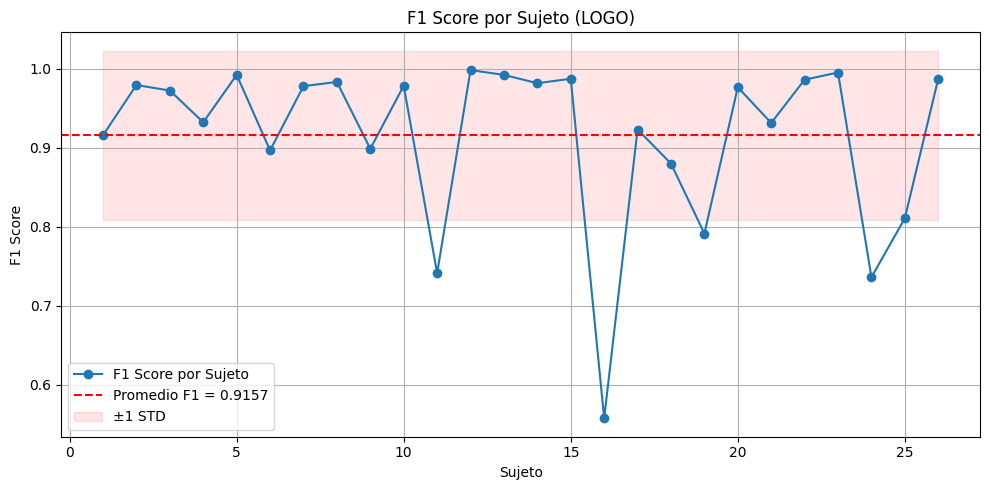


📌 Promedios generales:
Accuracy promedio: 0.8987 ± 0.1266
F1 Score promedio: 0.9157 ± 0.1073


In [14]:
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import f1_score, accuracy_score
from tensorflow.keras.models import load_model
import pandas as pd
import matplotlib.pyplot as plt

# Carpeta donde están tus modelos
MODEL_FOLDER = "modelos"
model_files = sorted([f for f in os.listdir(MODEL_FOLDER) if f.endswith(".h5")])

# Para almacenar resultados
results = []

logo = LeaveOneGroupOut()

split_num = 1
for train_idx, test_idx in logo.split(X_seq, y_seq, groups=subj_seq):
    model_path = os.path.join(MODEL_FOLDER, f"mejor_modelo_{split_num}.h5")
    if not os.path.exists(model_path):
        print(f"❌ Modelo no encontrado: {model_path}")
        split_num += 1
        continue

    print(f"✅ Evaluando modelo {split_num}")
    
    X_test = tf.cast(X_seq[test_idx], tf.float32)
    y_test = y_seq[test_idx]

    model = load_model(model_path)
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    unique, counts = np.unique(y_test, return_counts=True)
    class_dist = {f"class_{int(cls)}": int(count) for cls, count in zip(unique, counts)}

    results.append({
        "Sujeto": split_num,
        "Accuracy": acc,
        "F1 Score": f1,
        "Modelo": f"mejor_modelo_{split_num}.h5",
        **class_dist
    })

    split_num += 1

# Convertir a DataFrame
df_resultados = pd.DataFrame(results)

# -----------------------
# 🧾 Tabla resumida
# -----------------------
pd.set_option('display.float_format', lambda x: '%.4f' % x)
print("\n📊 Resultados por sujeto:")
print(df_resultados)

# -----------------------
# 📈 Gráfico resumen
# -----------------------
plt.figure(figsize=(10, 5))
plt.plot(df_resultados["Sujeto"], df_resultados["F1 Score"], marker='o', label="F1 Score por Sujeto")
plt.axhline(df_resultados["F1 Score"].mean(), color='r', linestyle='--', label=f"Promedio F1 = {df_resultados['F1 Score'].mean():.4f}")
plt.fill_between(df_resultados["Sujeto"],
                 df_resultados["F1 Score"].mean() - df_resultados["F1 Score"].std(),
                 df_resultados["F1 Score"].mean() + df_resultados["F1 Score"].std(),
                 color='r', alpha=0.1, label="±1 STD")

plt.title("F1 Score por Sujeto (LOGO)")
plt.xlabel("Sujeto")
plt.ylabel("F1 Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# -----------------------
# 🔢 Promedios generales
# -----------------------
print("\n📌 Promedios generales:")
print(f"Accuracy promedio: {df_resultados['Accuracy'].mean():.4f} ± {df_resultados['Accuracy'].std():.4f}")
print(f"F1 Score promedio: {df_resultados['F1 Score'].mean():.4f} ± {df_resultados['F1 Score'].std():.4f}")


In [15]:
# 📈 Análisis estadístico detallado
print("\n" + "="*60)
print("📈 ANÁLISIS ESTADÍSTICO DETALLADO")
print("="*60)

# Estadísticas por métrica
accuracy_stats = df_resultados['Accuracy'].describe()
f1_stats = df_resultados['F1 Score'].describe()

print(f"\n🎯 Estadísticas de Accuracy:")
print(f"   • Mínimo: {accuracy_stats['min']:.4f}")
print(f"   • Q1 (25%): {accuracy_stats['25%']:.4f}")
print(f"   • Mediana: {accuracy_stats['50%']:.4f}")
print(f"   • Q3 (75%): {accuracy_stats['75%']:.4f}")
print(f"   • Máximo: {accuracy_stats['max']:.4f}")
print(f"   • Desviación estándar: {accuracy_stats['std']:.4f}")

print(f"\n🎯 Estadísticas de F1 Score:")
print(f"   • Mínimo: {f1_stats['min']:.4f}")
print(f"   • Q1 (25%): {f1_stats['25%']:.4f}")
print(f"   • Mediana: {f1_stats['50%']:.4f}")
print(f"   • Q3 (75%): {f1_stats['75%']:.4f}")
print(f"   • Máximo: {f1_stats['max']:.4f}")
print(f"   • Desviación estándar: {f1_stats['std']:.4f}")

# Identificar mejores y peores sujetos
best_acc_idx = df_resultados['Accuracy'].idxmax()
worst_acc_idx = df_resultados['Accuracy'].idxmin()
best_f1_idx = df_resultados['F1 Score'].idxmax()
worst_f1_idx = df_resultados['F1 Score'].idxmin()

print(f"\n🏆 Mejores y peores resultados:")
print(f"   • Mejor Accuracy: Sujeto {df_resultados.loc[best_acc_idx, 'Sujeto']} ({df_resultados.loc[best_acc_idx, 'Accuracy']:.4f})")
print(f"   • Peor Accuracy: Sujeto {df_resultados.loc[worst_acc_idx, 'Sujeto']} ({df_resultados.loc[worst_acc_idx, 'Accuracy']:.4f})")
print(f"   • Mejor F1: Sujeto {df_resultados.loc[best_f1_idx, 'Sujeto']} ({df_resultados.loc[best_f1_idx, 'F1 Score']:.4f})")
print(f"   • Peor F1: Sujeto {df_resultados.loc[worst_f1_idx, 'Sujeto']} ({df_resultados.loc[worst_f1_idx, 'F1 Score']:.4f})")

# Confiabilidad del modelo
variability_acc = df_resultados['Accuracy'].std() / df_resultados['Accuracy'].mean()
variability_f1 = df_resultados['F1 Score'].std() / df_resultados['F1 Score'].mean()

print(f"\n📊 Consistencia del modelo (Coeficiente de Variación):")
print(f"   • Accuracy CV: {variability_acc:.4f} ({'Muy consistente' if variability_acc < 0.1 else 'Moderadamente consistente' if variability_acc < 0.2 else 'Variable'})")
print(f"   • F1 Score CV: {variability_f1:.4f} ({'Muy consistente' if variability_f1 < 0.1 else 'Moderadamente consistente' if variability_f1 < 0.2 else 'Variable'})")

# Umbral de rendimiento
good_performance_threshold = 0.8
excellent_performance_threshold = 0.9

good_acc_count = (df_resultados['Accuracy'] >= good_performance_threshold).sum()
excellent_acc_count = (df_resultados['Accuracy'] >= excellent_performance_threshold).sum()
good_f1_count = (df_resultados['F1 Score'] >= good_performance_threshold).sum()
excellent_f1_count = (df_resultados['F1 Score'] >= excellent_performance_threshold).sum()

total_subjects = len(df_resultados)

print(f"\n🎯 Distribución de rendimiento:")
print(f"   • Sujetos con Accuracy ≥ 80%: {good_acc_count}/{total_subjects} ({good_acc_count/total_subjects*100:.1f}%)")
print(f"   • Sujetos con Accuracy ≥ 90%: {excellent_acc_count}/{total_subjects} ({excellent_acc_count/total_subjects*100:.1f}%)")
print(f"   • Sujetos con F1 Score ≥ 80%: {good_f1_count}/{total_subjects} ({good_f1_count/total_subjects*100:.1f}%)")
print(f"   • Sujetos con F1 Score ≥ 90%: {excellent_f1_count}/{total_subjects} ({excellent_f1_count/total_subjects*100:.1f}%)")


📈 ANÁLISIS ESTADÍSTICO DETALLADO

🎯 Estadísticas de Accuracy:
   • Mínimo: 0.4882
   • Q1 (25%): 0.8741
   • Mediana: 0.9681
   • Q3 (75%): 0.9823
   • Máximo: 0.9982
   • Desviación estándar: 0.1266

🎯 Estadísticas de F1 Score:
   • Mínimo: 0.5576
   • Q1 (25%): 0.8974
   • Mediana: 0.9747
   • Q3 (75%): 0.9856
   • Máximo: 0.9985
   • Desviación estándar: 0.1073

🏆 Mejores y peores resultados:
   • Mejor Accuracy: Sujeto 12 (0.9982)
   • Peor Accuracy: Sujeto 16 (0.4882)
   • Mejor F1: Sujeto 12 (0.9985)
   • Peor F1: Sujeto 16 (0.5576)

📊 Consistencia del modelo (Coeficiente de Variación):
   • Accuracy CV: 0.1409 (Moderadamente consistente)
   • F1 Score CV: 0.1172 (Moderadamente consistente)

🎯 Distribución de rendimiento:
   • Sujetos con Accuracy ≥ 80%: 21/26 (80.8%)
   • Sujetos con Accuracy ≥ 90%: 17/26 (65.4%)
   • Sujetos con F1 Score ≥ 80%: 22/26 (84.6%)
   • Sujetos con F1 Score ≥ 90%: 18/26 (69.2%)
